# Personal Information
Name: **Roderick Majoor**

StudentID: **12852724**

Email: [**roderick.majoor@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context
The dataset used in this study consists of pages from the collection
of ledgers from the Bank of Amsterdam. The full collection can be
found on the website of The Amsterdam City Archives. In the series
of ledgers, the current accounts of the customers were maintained.
Each customer had one or more pages, with smaller traders having
a portion of a page. An alphabetical list of the traders and the page
of their current account can be found in the index. The ledgers kept
track of the amounts that were debited and credited from and to a
customer. The ledger pages consist of several columns containing
information such as the date, account holder name, account number
and amount debited/credited.

# Data Description

Currently, a tool called Loghi is used to perform handwritten text recognition on these pages. This tool has its flaws though, and in this thesis we are trying to determine what the major errors are and how we could possibly solve them.

From the analysis show below we find the following:
1. False positives detected (typically due to marks / stripes on the image that are recognized as text)
2. Numbers are not detected as numbers but rather as text / other characters
3. Words/numbers are merged or seperated (i.e. 16 becomes 1, 6 or 2, 8 becomes 28 etc.)
4. Numbers not correctly recognized (i.e. 16 becomes 18 etc.)
5. Output not in the correct layout

Some of the code used is quite long, so instead of putting everything in this notebook, we will just import it from their scripts. The scripts can be found on the GitHub:

In [46]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import jiwer
import cv2

from compare_GT_data_textlines import main

### Data Loading

In [2]:
# Path to the folder containing the images
data_dir = "/home/roderickmajoor/Desktop/Master/Thesis/GT_data"

# List to store paths of all image files
image_paths = []

# Iterate through the folder structure
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Check if the file is an image (you can add additional checks if needed)
        if file.endswith(".jpg") or file.endswith(".png"):
            # Construct the full path to the image file
            image_path = os.path.join(root, file)
            # Append the image path to the list
            image_paths.append(image_path)

### Analysis 1: Visualizing Data
Here we show a couple of the images in our dataset. This already shows us a couple of things. First of all, the sizes of the images are not always the same. The first 3 images are larger than image 4 and 5. The first 3 images also seem to have a more 'neat' layout where text does not flow over into other text. The layout on image 4 and 5 seems a bit more chaotic. Other noticable things are stains on some of the pages and also stripes/marks that go through some of the text which may cause problems when analysing it.

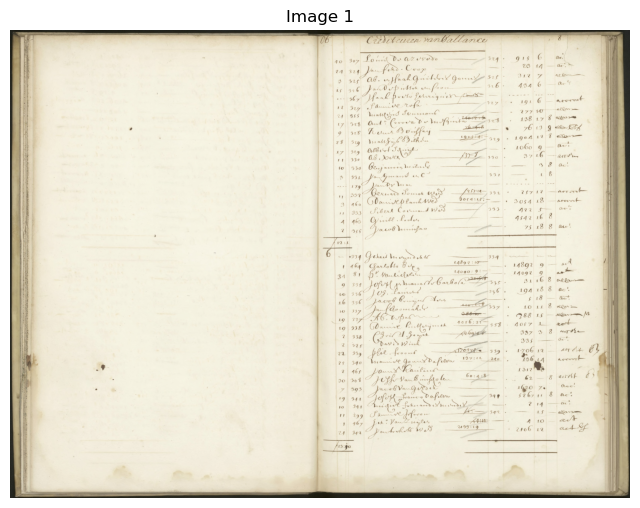

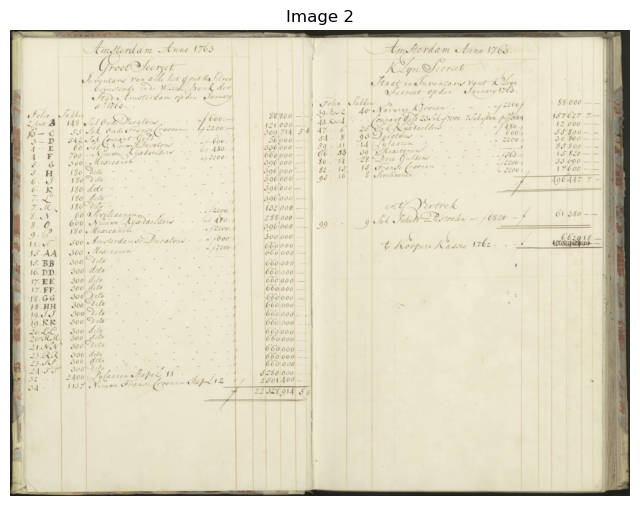

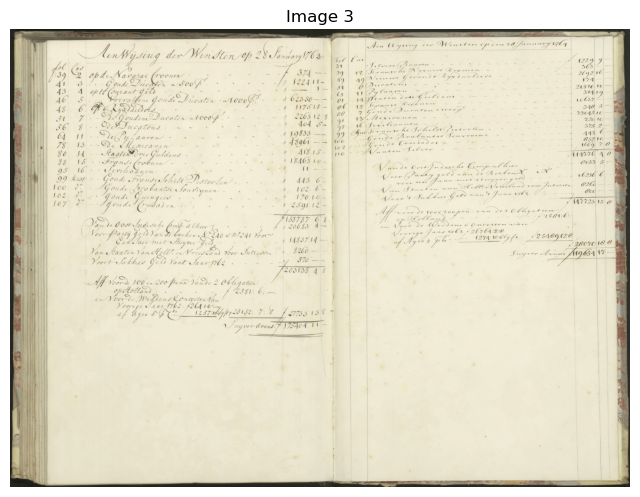

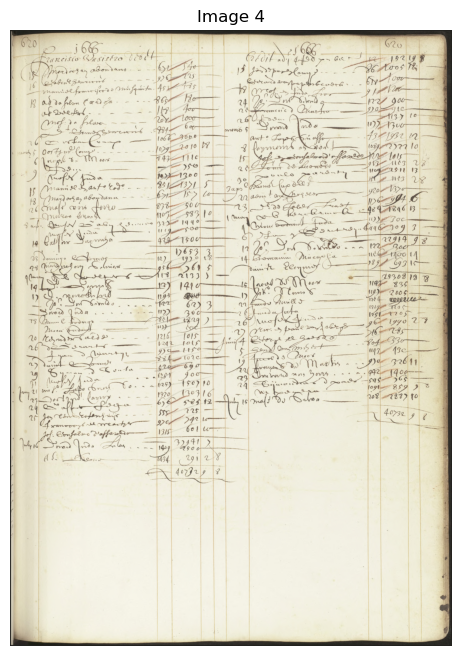

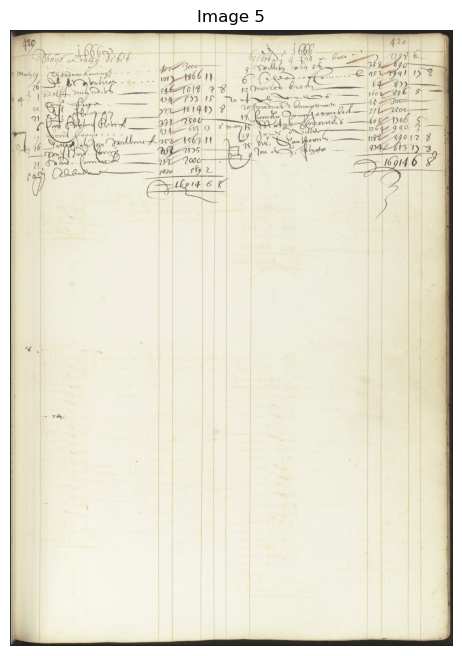

In [3]:
# Set the number of images to visualize
num_images_to_visualize = 5

# Visualize a sample of the images
for i in range(num_images_to_visualize):
    # Read the image using matplotlib
    image = mpimg.imread(image_paths[i])
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Image {i+1}")  # Set title
    plt.show()

We show the length of the image dataset, print the unique sizes of the images in it and show the color channels to show if all images are in color.

In [32]:
print(len(image_paths))

unique_sizes = set()
channels_images = set()

for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])
        
    (height, width, channels) = img.shape
    unique_sizes.add((height, width))
    channels_images.add(channels)

print(unique_sizes)
print(channels_images)


68
{(6440, 4832), (5990, 4241), (6159, 4431), (6370, 4852), (6380, 4802), (6310, 4722), (5923, 4041), (6434, 4446), (6046, 4374), (6310, 4792), (6380, 4582), (6002, 4349), (6219, 4451), (6280, 4702), (5927, 4105), (6260, 4672), (6390, 4772), (5370, 3782), (6250, 4536), (6350, 4742), (4318, 5882), (6430, 4802), (6056, 4359), (5178, 6882), (5931, 4035), (6260, 4586), (6061, 4349), (6053, 4351), (6290, 4486), (5929, 4065), (6260, 4662), (6290, 4556), (6061, 4367), (6075, 4360), (6510, 4642), (5189, 7031), (6310, 4742), (5993, 4263), (5992, 4228), (5963, 4250), (6191, 4454), (6290, 4812), (6360, 4526), (5980, 4287), (6390, 4722), (4927, 6747), (5001, 6629), (5074, 3587), (6510, 4742), (6380, 4520), (6280, 4682), (6052, 4342), (5923, 4164), (5971, 4247), (6410, 4762), (6530, 4732), (6247, 4392), (6063, 4391), (6330, 4622), (4310, 5921), (5100, 3785), (5179, 3816), (6059, 4445), (5991, 4301), (6240, 4682), (5918, 4061), (6330, 4762), (5196, 3734)}
{3}


### Analysis 2: 
We need to understand our data. Since we are working with images, the important features of the images are stored in an XML file. The XML files contain the information about the images such as at what coordinates text regions, text lines, words etc. occur. To visualize these features, we plot the XML data over the original image so we can better understand the data. In the first cell, we do this for the ground truth XML file, which is hand annotated. In the second cell, we show this for the currently used tool to analyse these pages Loghi. Comparing these features can give us an indication about the performance of the currently used tool.

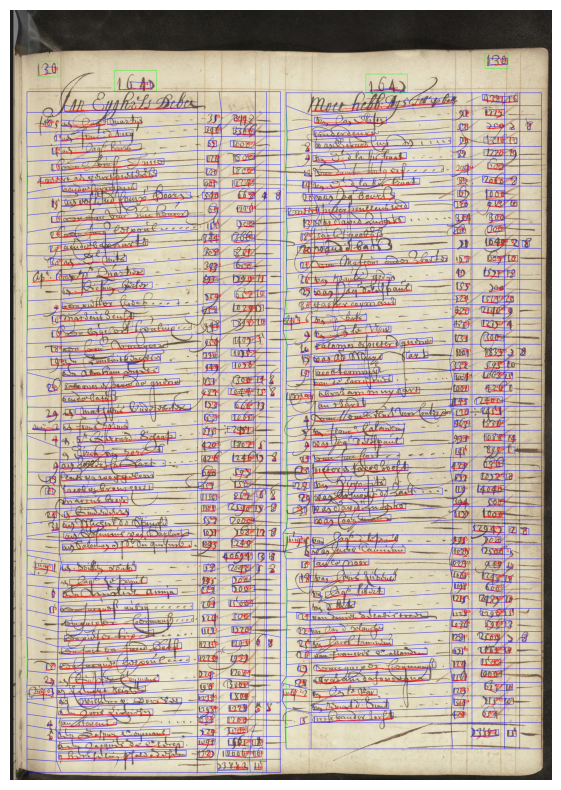

In [4]:
# Cell 1: Run the GT script
%run xml_on_image_GT.py

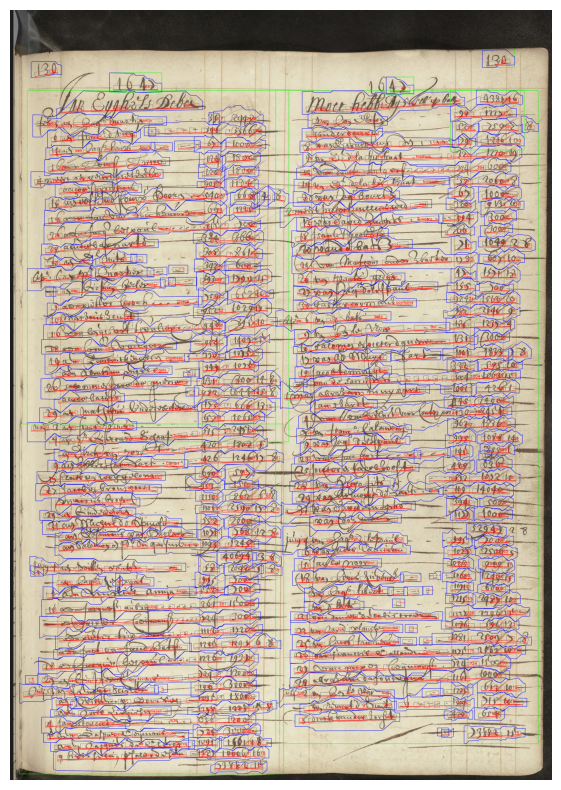

In [5]:
# Cell 2: Run the Loghi script
%run xml_on_image_loghi.py

In [6]:
def extract_text_from_xml_gt(xml_file):
    ns = {'page': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
    
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract text content from all TextEquiv elements
    text_content = []
    for text_equiv in root.findall('.//page:TextEquiv', ns):
        text = text_equiv.find('page:Unicode', ns).text
        if text:
            text_content.append(text)
    
    return text_content

def extract_text_from_xml_loghi(xml_file):
    ns = {'page': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
    
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract text content from all TextEquiv elements
    text_content = []
    for word in root.findall('.//page:Word', ns):
        text_equiv = word.find('page:TextEquiv', ns)
        if text_equiv is not None:
            text = text_equiv.find('page:Unicode', ns).text
            if text:
                text_content.append(text)
    
    return text_content

Lets now show all the words in our ground truth XML file for this image. Note that in the ground truth file, the names in the credit/debit tables are not included, so we merely focus on the money amounts and dates

In [7]:
xml_file_path = '/home/roderickmajoor/Desktop/Master/Thesis/GT_data/55/page/WBMA00007000010.xml'
all_text_gt = extract_text_from_xml_gt(xml_file_path)
print(all_text_gt)

['130', '130', '1647', 'feb 5', '35', '2448', '6', '346', '3366', '14', '67', '1000', '16', '124', '1800', '4 mrt', '120', '1800', '905', '1134', '15', '540', '668', '4', '8', '16', '69', '1225', '26', '155', '700', '29', '344', '366', '30', '308', '861', 'Ap 6', '343', '600', '593', '1799', '15', '9', '709', '652', '10', '10', '952', '1029', '17', '16', '948', '895', '10', '18', '954', '1407', '5', '19', '330', '1075', '949', '1075', '20', '131', '300', '14', '8', '982', '1044', '15', '8', '29', '173', '666', '13', 'may 2', '658', '1065', '4', '515', '2451', '420', '1802', '5', '9', '426', '1246', '17', '8', '17', '690', '597', '27', '553', '150', '1150', '862', '6', '8', '29', '1101', '2590', '17', '8', '31', '552', '2000', '1071', '768', '12', '8', '1093', '1245', '40694', '3', '8', 'july 1', '58', '2043', '5', '8', '995', '700', '5', '552', '700', '15', '261', '1500', '724', '300', '1112', '1720', '1215', '1291', '6', '8', '18', '1226', '1937', '27', '724', '1200', 'July 3', '196',

Comparing this XML to the ground truth image above, we can see that the XML follows the tabular structure where its goes through the rows of the tables. Now we show the XML output for the Loghi tool

In [8]:
xml_file_path = '/home/roderickmajoor/Desktop/Master/Thesis/loghi/data/55/page/WBMA00007000010.xml'
all_text_loghi = extract_text_from_xml_loghi(xml_file_path)
print(all_text_loghi)

['130', 'Jan', 'Eijghels', 'Deben', 'feb:', '5', 'aen', 'Paqe.', 'Martijn', '35', 'ƒ', '2448', '-', '-', '-', '-', '-', '346', 'ƒ', '3366', '6', 'aen', 'Franc.', "d'vicq", '-67', '1000', '—', '-', '14', 'aen', 'Jage.', 'bours', '1800', '124', '160n', 'Lourisz', 'Lusse', '1800', '1120', 't', 'meert', 'aen', 'geurt', 'Pietersz', '905', '1134', 'aende', 'Coupans', '668', '8', '4', '15', 'aende', 'oost', "Ind'", 'Compe.', 'Hoorn', '540', '1225', '16', 'aent', 'fait', 'van', 'Wickenoort', '69', '26', 'aot', 'Jacq', 'lespoul', '„55', 'ƒ', '100', '844', '366', '29', 'aende', 'barnarts', '308', 'ƒ', '861', '„', 'mits', '30', 'aen', '600', '.', '342', '—', '—', 'Quartier', 'apn.', 'Caextpr.', '179', '9', 'ƒ', '15', '692', '-', '-', '—', 'aen.', 'Piosuim', 'Heller', '652/0', 'p09', '9', 'aen', 'pietter', 'Cloeck', 'f', '52', '10291', '10,', 'Matheus', 'Senst', 'Ro10', '16', 'aer', 'hijsbert', 'theulinx', 'ƒ', '948', '954', '1407', 'ƒ', '5', '28', 'aen', 'Corn.', 'vangoor', '1075', '330', '19', '

Looking at the Loghi XML output and image, we can see that (besides the recognized names which we discarded in the ground truth) a lot of false positives are detected, mainly '.' and '-' characters that are typically detected due to small marks/stripes on the image. In order to get better results, we should try to pre-process our image such that these marks/stripes are not detected as text.

For now let's just get rid of the elements in the XML files that don't contain numbers. This should give us a better comparison of the numbers found and might tell us something about the order of the Loghi XML file.

In [9]:
filtered_list = [item for item in all_text_loghi if any(char.isdigit() for char in item)]

print(filtered_list)

['130', '5', '35', '2448', '346', '3366', '6', '-67', '1000', '14', '1800', '124', '160n', '1800', '1120', '905', '1134', '668', '8', '4', '15', '540', '1225', '16', '69', '26', '„55', '100', '844', '366', '29', '308', '861', '30', '600', '342', '179', '9', '15', '692', '652/0', 'p09', '9', '52', '10291', '10,', 'Ro10', '16', '948', '954', '1407', '5', '28', '1075', '330', '19', '949', '1078', '131', '300', '148', '26', '982', '1044f158', '173', '666', '13', '29', '658', '1065', '2', '4', '515.', '2451', '420', '1802', '5', '426', '124613', '8', '9', '690', '597', '150', 'S53', '27', '1186', '862', '68', '1101', '2590', '17', '8', '29', '552', '2000', '31', '768', '128', '1071', '1093', '1245', '40694', '38', '58', '2042', '5', '58', '5.', '295', '300', '5552', '100', '5', '15', '261', '1500', '124', '300-', '1112', '1720', '1215', '129', '6', '8.', '18', '1226', '1931', '27', 'f24', '1200', '1', '196', '3000', '1235', '1800', '1298', '1228', '55', '636', '1200', '4', '724', '3000-', '

In [10]:
print(len(all_text_gt))
print(len(filtered_list))

341
314


Now, The list of numbers in the Loghi detected text is shorter than the ground truth list. This is because some of the numbers in the ground truth are actually not recognized as numbers by Loghi. This is another error in Loghi that we should try to improve. Other things we notice are that there are some words/numbers that become merged in Loghi's detection. The last thing that we can see from the images and lists, is that Loghi is not able to capture the table structure of the page correctly thus creating a wrong order of words in the list.

Some of the things we noticed going wrong in Loghi's output:
1. False positives detected (typically due to marks / stripes on the image that are recognized as text)
2. Numbers are not detected as numbers but rather as text / other characters
3. Words/numbers are merged or seperated (i.e. 16 becomes 1, 6 or 2, 8 becomes 28 etc.)
4. Numbers not correctly recognized (i.e. 16 becomes 18 etc.)
5. Output not in the correct layout

### Analysis 3:
We can try to find the Word Error Rate (WER) and Character Error Rate (CER) from the output of Loghi. However, since we have a shorter list as Loghi output than the ground truth and we know the order is not correct, we can expect a very bad score.

In [14]:
wer = jiwer.wer(all_text_gt[:314], filtered_list)
cer = jiwer.cer(all_text_gt[:314], filtered_list)
print("Word Error Rate:", wer)
print("Character Error Rate:", cer)

Word Error Rate: 0.9783950617283951
Character Error Rate: 1.0684150513112884


We will check if there are matching words in both lists. Here we do not look at word order, merely if a word occurs somewhere in both lists. This at least gives us an idea whether Loghi has some matching words with the ground truth.

In [16]:
def count_matching_words(list1, list2):
    # Convert lists to dictionaries to count occurrences
    dict1 = {}
    dict2 = {}
    
    # Count occurrences in list 1
    for word in list1:
        dict1[word] = dict1.get(word, 0) + 1
    
    # Count occurrences in list 2
    for word in list2:
        dict2[word] = dict2.get(word, 0) + 1
    
    # Find the intersection of the two dictionaries
    matching_words = set(dict1.keys()).intersection(set(dict2.keys()))
    
    # Count the occurrences based on the minimum count in both lists
    total_count = sum(min(dict1.get(word, 0), dict2.get(word, 0)) for word in matching_words)
    
    return total_count

In [19]:
matching_count = count_matching_words(all_text_gt, filtered_list)
print("Number of matching words:", matching_count)

Number of matching words: 215


We find 215 matching words for this page, out of 314 total words in the (filtered) Loghi output. So about 68% of Loghi's output is also found in the ground truth. However, we still have no idea about the correct word order.

We can also calculate the jaccard similarity score

In [20]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return intersection / union if union != 0 else 0

In [21]:
print("Jaccard Similarity:", jaccard_similarity(all_text_gt, filtered_list))

Jaccard Similarity: 0.4708029197080292


Now lets show the mean metrics for all images

In [39]:
def get_all_xml_files(root_directory):
    xml_files = []
    for root, _, files in os.walk(root_directory):
        for file in files:
            if file.endswith(".xml"):
                xml_files.append(os.path.join(root, file))
    return xml_files

all_xml_GT = get_all_xml_files('/home/roderickmajoor/Desktop/Master/Thesis/GT_data/')
all_xml_loghi = get_all_xml_files('/home/roderickmajoor/Desktop/Master/Thesis/loghi/data/')

list1_filenames = [os.path.basename(path) for path in all_xml_GT]
list2_filenames = [os.path.basename(path) for path in all_xml_loghi]
if list1_filenames == list2_filenames:
    print("The lists are in the same order based on filenames.")

The lists are in the same order based on filenames.


In [44]:
def compute_mean_metrics(all_xml_GT, all_xml_loghi):

    wer_total = 0
    cer_total = 0
    matching_count_total = 0
    jaccard_similarity_total = 0
    num_images = 0

    for data_gt, data_loghi in zip(all_xml_GT, all_xml_loghi):
        all_text_gt = extract_text_from_xml_gt(data_gt)
        all_text_loghi = extract_text_from_xml_loghi(data_loghi)
        filtered_list = [item for item in all_text_loghi if any(char.isdigit() for char in item)]
        wer_total += jiwer.wer(all_text_gt[:len(filtered_list)], filtered_list[:len(all_text_gt)])
        cer_total += jiwer.cer(all_text_gt[:len(filtered_list)], filtered_list[:len(all_text_gt)])
        matching_count_total += count_matching_words(all_text_gt, filtered_list) / len(filtered_list)
        jaccard_similarity_total += jaccard_similarity(all_text_gt, filtered_list)
        num_images += 1

    mean_wer = wer_total / num_images
    mean_cer = cer_total / num_images
    mean_matching_count = matching_count_total / num_images
    mean_jaccard_similarity = jaccard_similarity_total / num_images

    return mean_wer, mean_cer, mean_matching_count, mean_jaccard_similarity

In [45]:
mean_wer, mean_cer, mean_matching_count, mean_jaccard_similarity = compute_mean_metrics(all_xml_GT, all_xml_loghi)

print("Mean Word Error Rate:", mean_wer)
print("Mean Character Error Rate:", mean_cer)
print("Mean Matching Count:", mean_matching_count)
print("Mean Jaccard Similarity:", mean_jaccard_similarity)

Mean Word Error Rate: 0.9810198160684107
Mean Character Error Rate: 1.0649680926496443
Mean Matching Count: 0.6609155616036941
Mean Jaccard Similarity: 0.4582747425528701


As we expected, we can see a bad score for WER and CER (mainly because of the word order) and we see that the mean matching count and jaccard similarity show that loghi does manage do get some output correct.

### Analysis 3:
Now we will match the bounding boxes of the table cells in the ground truth with the bounding boxes of words found by loghi based on their intersection over union value. This way, we can see the correct order. We will do this for the first image again.

In [47]:
data_gt, data_loghi = main()

['130', '130', '1647', '1647', 'feb 5', '35', '2448', '6', '346', '3366', '14', '67', '1000', '16', '124', '1800', '4 mrt', '120', '1800', '905', '1134', '15', '540', '668', '4', '8', '16', '69', '1225', '26', '155', '700', '29', '344', '366', '30', '308', '861', 'Ap 6', '343', '600', '593', '1799', '15', '9', '709', '652', '10', '952', '1029', '16', '948', '895', '18', '954', '1407', '5', '19', '330', '1075', '949', '1075', '20', '131', '300', '14', '982', '1044', '29', '173', '666', '13', 'may 2', '658', '1065', '4', '515', '2451', '420', '1802', '5', '9', '426', '1246', '8', '17', '690', '597', '27', '553', '150', '1150', '862', '6', '29', '1101', '2590', '17', '8', '31', '552', '2000', '1071', '768', '12', '1093', '1245', '40694', '3', 'july 1', '58', '2043', '5', '8', '995', '700', '5', '552', '700', '15', '261', '1500', '724', '300', '1112', '1720', '1215', '1291', '6', '8', '18', '1226', '1937', '27', '724', '1200', 'July 3', '196', '3000', '1235', '1800', '1298', '1228', '5', '

In [50]:
print(data_gt)
print(data_loghi)

['130', '130', '1647', '1647', 'feb 5', '35', '2448', '6', '346', '3366', '14', '67', '1000', '16', '124', '1800', '4 mrt', '120', '1800', '905', '1134', '15', '540', '668', '4', '8', '16', '69', '1225', '26', '155', '700', '29', '344', '366', '30', '308', '861', 'Ap 6', '343', '600', '593', '1799', '15', '9', '709', '652', '10', '952', '1029', '16', '948', '895', '18', '954', '1407', '5', '19', '330', '1075', '949', '1075', '20', '131', '300', '14', '982', '1044', '29', '173', '666', '13', 'may 2', '658', '1065', '4', '515', '2451', '420', '1802', '5', '9', '426', '1246', '8', '17', '690', '597', '27', '553', '150', '1150', '862', '6', '29', '1101', '2590', '17', '8', '31', '552', '2000', '1071', '768', '12', '1093', '1245', '40694', '3', 'july 1', '58', '2043', '5', '8', '995', '700', '5', '552', '700', '15', '261', '1500', '724', '300', '1112', '1720', '1215', '1291', '6', '8', '18', '1226', '1937', '27', '724', '1200', 'July 3', '196', '3000', '1235', '1800', '1298', '1228', '5', '

Now we will perform the same tests as before

In [51]:
wer = jiwer.wer(data_gt, data_loghi)
cer = jiwer.cer(data_gt, data_loghi)
matching_count = count_matching_words(data_gt, data_loghi) / len(data_loghi)
jaccard_similarity = jaccard_similarity(data_gt, data_loghi)

print("Word Error Rate:", wer)
print("Character Error Rate:", cer)
print("Matching Count:", matching_count)
print("Jaccard Similarity:", jaccard_similarity)

Word Error Rate: 0.38198757763975155
Character Error Rate: 0.2139689578713969
Matching Count: 0.6495176848874598
Jaccard Similarity: 0.45


Now we have way better scores for word error and character error. However we could not match every ground truth word to a loghi word based on IoU. Only 311 out of 341 ground truth regions were matched to a loghi region. But this does show that if we can find the correct layout from the loghi output, the performance will drastically increase.